# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import warnings
import plotly.express as px
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import sklearn
from sklearn.preprocessing import OneHotEncoder ,StandardScaler
from sklearn.impute import SimpleImputer
 
# magic word for producing visualizations in notebook
%matplotlib inline

pd.options.display.max_rows = None
pd.options.display.max_columns = None

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [11]:
# Load in the general demographics data.
demographicData=pd.read_csv('Udacity_AZDIAS_Subset.csv',sep=';', on_bad_lines='warn')
FeatureSummary=pd.read_csv('AZDIAS_Feature_Summary.csv',sep=';', on_bad_lines='warn')

'GEBAEUDETYP_5.0' in FeatureSummary['attribute']

False

In [12]:
print('number of rows :' , demographicData.shape[0])
print('number of columns :' , demographicData.shape[1])
display(demographicData.head(5))

number of rows : 891221
number of columns : 85


AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   
3         2                     4          2            2.0   
4        -1                     3          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  FINANZTYP  GEBURTSJAHR  \
0                      5                 3          4            0   
1                      4                 5          1         1996   
2                      3                 5          1         1979   
3                      1                 2          6         1957   
4                      3                 2          5         1963   

   GFK_URLAUBERTYP  GREEN_AVANTGARDE  HEALTH_TYP  LP_LEBENSPHASE_FEIN  \
0             10.0                 0          -1                 15.0   
1             10.0                 0           3                 21.0   
2             10.0                 1           3                  3.0   
3              1.0                 0           2                  0.0   
4              5.0                 0           3                 32.0   

   LP_LEBENSPHASE_GROB  LP_FAMILIE_FEIN  LP_FAMILIE_GROB  LP_STATUS_FEIN  \
0                  4.0              2.0              2.0             1.0   
1                  6.0              5.0              3.0             2.0   
2                  1.0              1.0              1.0             3.0   
3                  0.0              0.0              0.0             9.0   
4                 10.0             10.0              5.0             3.0   

   LP_STATUS_GROB  NATIONALITAET_KZ  PRAEGENDE_JUGENDJAHRE  RETOURTYP_BK_S  \
0             1.0                 0                      0             5.0   
1             1.0                 1                     14             1.0   
2             2.0                 1                     15             3.0   
3             4.0                 1                      8             2.0   
4             2.0                 1                      8             5.0   

   SEMIO_SOZ  SEMIO_FAM  SEMIO_REL  SEMIO_MAT  SEMIO_VERT  SEMIO_LUST  \
0          2          6          7          5           1           5   
1          5          4          4          3           1           2   
2          4          1          3          3           4           4   
3          5          1          2          1           4           4   
4          6          4          4          2           7           4   

   SEMIO_ERL  SEMIO_KULT  SEMIO_RAT  SEMIO_KRIT  SEMIO_DOM  SEMIO_KAEM  \
0          3           3          4           7          6           6   
1          2           3          6           4          7           4   
2          6           3          4           7          7           7   
3          7           4          3           4          4           5   
4          4           6          2           3          2           2   

   SEMIO_PFLICHT  SEMIO_TRADV  SHOPPER_TYP  SOHO_KZ  TITEL_KZ  VERS_TYP  \
0              5            3           -1      NaN       NaN        -1   
1              7            6            3      1.0       0.0         2   
2              3            3            2      0.0       0.0         1   
3              4            4            1      0.0       0.0         1   
4              4            2            2      0.0       0.0         2   

   ZABEOTYP  ALTER_HH  ANZ_PERSONEN  ANZ_TITEL  HH_EINKOMMEN_SCO

In [13]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

print('number of rows :' , FeatureSummary.shape[0])
print('number of columns :' , FeatureSummary.shape[1])
display(FeatureSummary.loc[FeatureSummary['attribute']=='PRAEGENDE_JUGENDJAHRE'].head(4))

number of rows : 85
number of columns : 4


attribute information_level   type missing_or_unknown
22  PRAEGENDE_JUGENDJAHRE            person  mixed             [-1,0]

In [14]:

FeatureSummary['type'].unique()

 

array(['categorical', 'ordinal', 'numeric', 'mixed', 'interval'],
      dtype=object)

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [15]:
# Identify missing or unknown data values and convert them to NaNs.

#FeatureSummary['missing_or_unknown']=FeatureSummary['missing_or_unknown'].apply(lambda x : eval(x))

for attribute , missValue in FeatureSummary[['attribute' ,'missing_or_unknown' ]].values :
        missValue=missValue[1:-1]
        missValue = missValue.split(',')
        for x in  missValue  : 
            try :
                demographicData[attribute].replace(int(x),np.NAN , inplace=True)  
            except :
                demographicData[attribute].replace(x ,np.NAN , inplace=True)

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [16]:
# Perform an assessment of how much missing data there is in each column of the

missingValuepercent=demographicData.isna().sum()/len(demographicData)*100
 
missingValuepercent

AGER_TYP                 76.955435
ALTERSKATEGORIE_GROB      0.323264
ANREDE_KZ                 0.000000
CJT_GESAMTTYP             0.544646
FINANZ_MINIMALIST         0.000000
FINANZ_SPARER             0.000000
FINANZ_VORSORGER          0.000000
FINANZ_ANLEGER            0.000000
FINANZ_UNAUFFAELLIGER     0.000000
FINANZ_HAUSBAUER          0.000000
FINANZTYP                 0.000000
GEBURTSJAHR              44.020282
GFK_URLAUBERTYP           0.544646
GREEN_AVANTGARDE          0.000000
HEALTH_TYP               12.476816
LP_LEBENSPHASE_FEIN      10.954859
LP_LEBENSPHASE_GROB      10.611509
LP_FAMILIE_FEIN           8.728699
LP_FAMILIE_GROB           8.728699
LP_STATUS_FEIN            0.544646
LP_STATUS_GROB            0.544646
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
RETOURTYP_BK_S            0.544646
SEMIO_SOZ                 0.000000
SEMIO_FAM                 0.000000
SEMIO_REL                 0.000000
SEMIO_MAT                 0.000000
SEMIO_VERT          

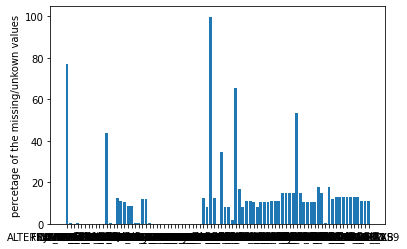

In [17]:
# Investigate patterns in the amount of missing data in each column.
plt.figuer(figsize=(10,10))
plt.bar(missingValuepercent.index , missingValuepercent.values , )
plt.ylabel('percetage of the missing/unkown values')
plt.show()



In [18]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

outier_columns=missingValuepercent[missingValuepercent>20].index

#removing outlier from FeatureSummary
outlierMask=[x not in outier_columns for x in  FeatureSummary['attribute'].values]
FeatureSummary=FeatureSummary[outlierMask]

#removing outlier from demographicData
demographicData.drop(outier_columns , axis=1 ,inplace=True)

In [19]:
 
demographicData.isna().sum().sum()
outier_columns

Index(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
       'KBA05_BAUMAX'],
      dtype='object')

#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

KK_KUNDENTYP this feature has more than 60% of unkown or missing , it will be dropped

other features has around 10% NANs 


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [20]:
# How much data is missing in each row of the dataset?
row_missingValue=demographicData.isna().sum(axis=1)  

In [21]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
threshold=10
little_nans=demographicData[ row_missingValue<threshold]
alot_nans=demographicData[ row_missingValue>threshold] 

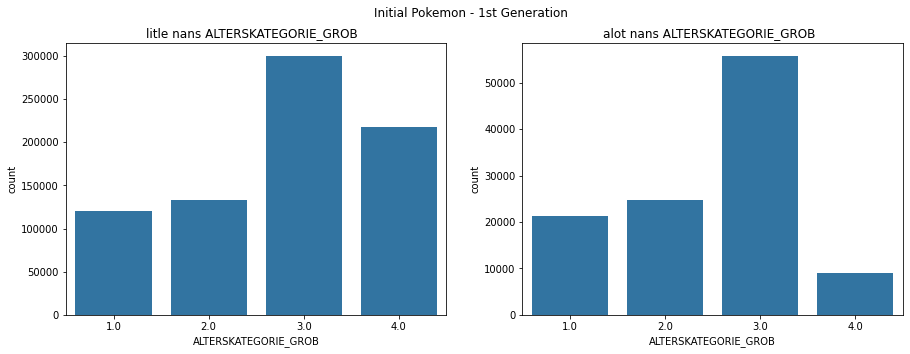

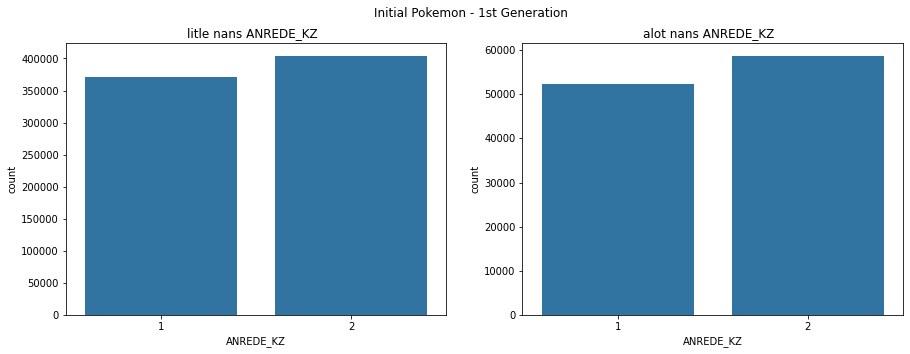

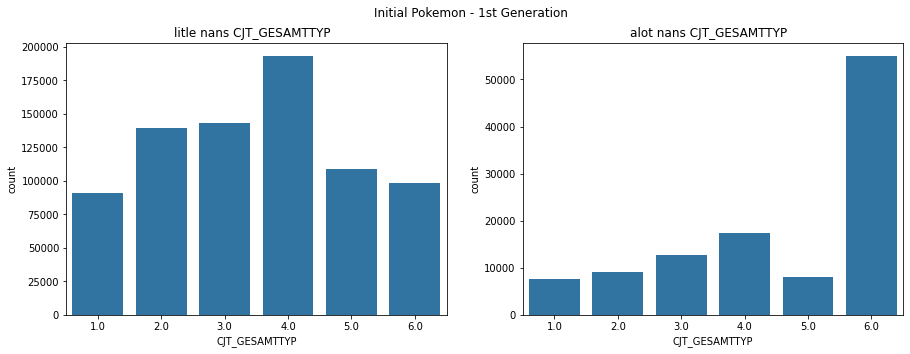

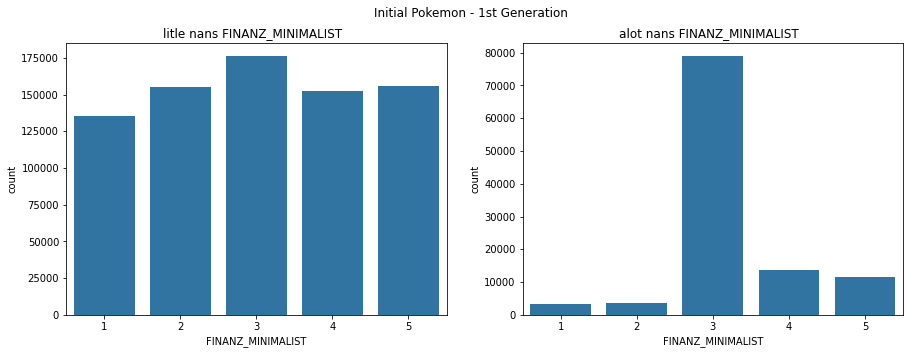

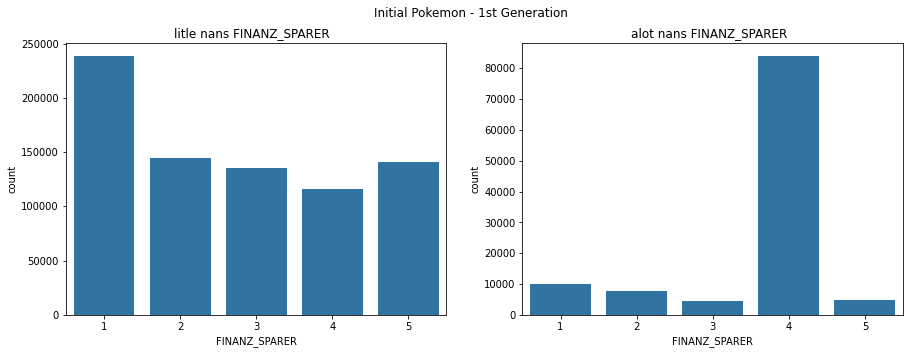

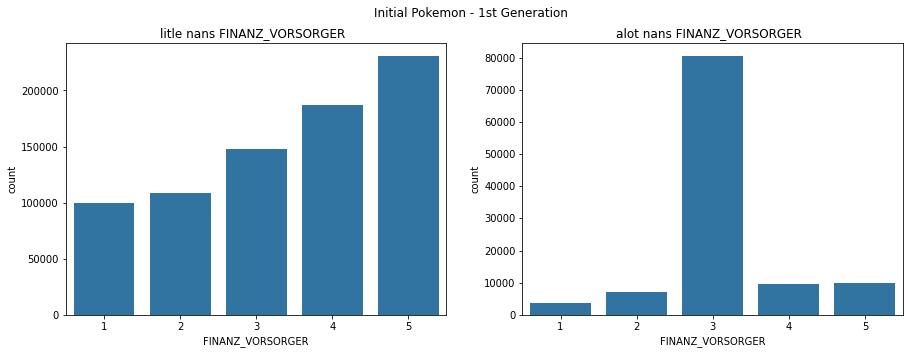

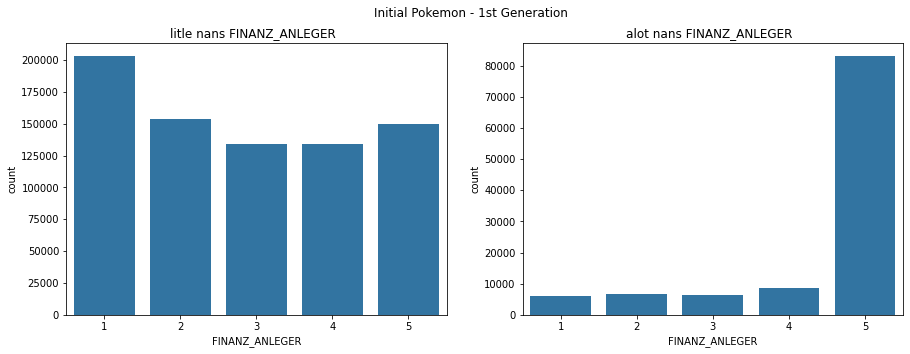

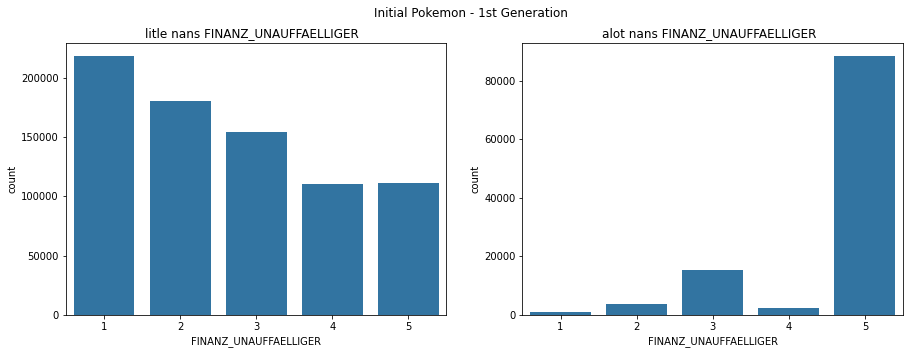

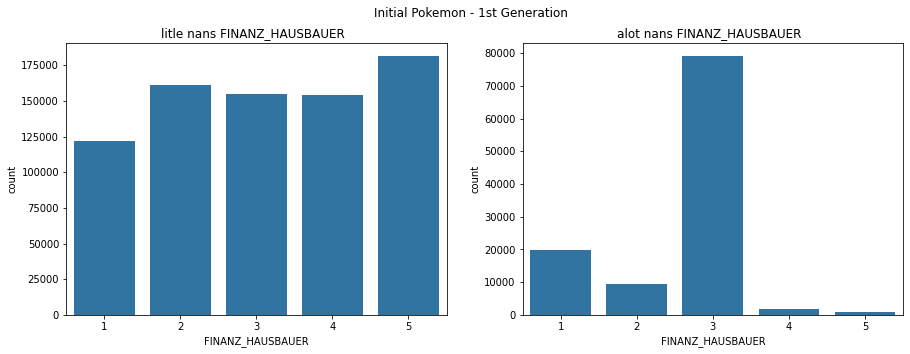

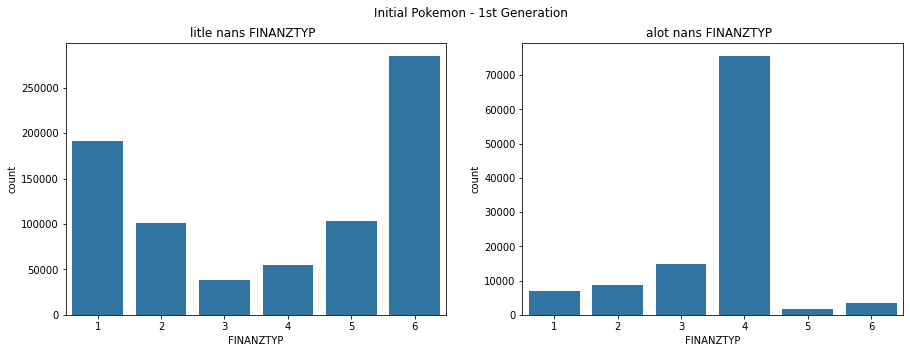

In [22]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
 
for clm in little_nans.columns[:10] :
    fig, axes = plt.subplots(1, 2, figsize=(15, 5)   )
    fig.suptitle('Initial Pokemon - 1st Generation')

    # Bulbasaur
    sns.countplot(ax=axes[0], data=little_nans ,
                  x=clm)
    axes[0].set_title(f'litle nans {clm}  ')

    # Charmander
    sns.countplot(ax=axes[1],data=alot_nans ,
                  x= clm)
    axes[1].set_title(f'alot nans {clm}  ')

    plt.show()

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

the data with litle Nans doesnot have the same distribution for the data with alot of nans 

so we continue with the data with the little amount of NAN

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [23]:
# How many features are there of each data type?
mixedFeatures=FeatureSummary['attribute'].loc[FeatureSummary['type']=='mixed']
mixedFeatures=mixedFeatures.values

print('counting the feature of each type')
print(FeatureSummary['type'].value_counts())

print('Mixed Features :' )
print(mixedFeatures)

counting the feature of each type
type
ordinal        49
categorical    18
mixed           6
numeric         6
Name: count, dtype: int64
Mixed Features :
['LP_LEBENSPHASE_FEIN' 'LP_LEBENSPHASE_GROB' 'PRAEGENDE_JUGENDJAHRE'
 'WOHNLAGE' 'CAMEO_INTL_2015' 'PLZ8_BAUMAX']


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [24]:
FeatureSummary[FeatureSummary['attribute']=='PRAEGENDE_JUGENDJAHRE']


attribute information_level   type missing_or_unknown
22  PRAEGENDE_JUGENDJAHRE            person  mixed             [-1,0]

In [25]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

multi_level_features=[]
binary_level_features=[]
 
catfeatures=FeatureSummary.loc[ FeatureSummary['type']=='categorical'   ]
 
for att in catfeatures['attribute'] : 
    levels=len(little_nans[att].value_counts() )
    if levels <=2 :
        binary_level_features.append(att)
    else :
        multi_level_features.append(att)
        

In [26]:
# Re-encode categorical variable(s) to be kept in the analysis.

data=pd.get_dummies(little_nans,  
                    dummy_na=False, columns=multi_level_features)
data.dropna(inplace=True)

In [27]:
data['PRAEGENDE_JUGENDJAHRE'].unique()

array([14., 15.,  8.,  3., 10., 11.,  9.,  5.,  4.,  2.,  6.,  1., 12.,
       13.,  7.])

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

have decided to  OneHotEncoder for the mulit level categorial variable 
if we drop them , we will loss data which might be crucial for the model 
so it is better to encode them and utilise a dimensionality reduction technique  

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [28]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
def PRAEGENDE_JUGENDJAHRE_features (x)  :
        PRAEGENDE_JUGENDJAHRE_labels={ 
          1: '40s - war years (Mainstream, E+W)',
          2: '40s - reconstruction years (Avantgarde, E+W)',
          3: '50s - economic miracle (Mainstream, E+W)',
          4: '50s - milk bar / Individualisation (Avantgarde, E+W)',
          5: '60s - economic miracle (Mainstream, E+W)',
          6: '60s - generation 68 / student protestors (Avantgarde, W)',
          7: '60s - opponents to the building of the Wall (Avantgarde, E)',
          8: '70s - family orientation (Mainstream, E+W)',
          9: '70s - peace movement (Avantgarde, E+W)',
         10: '80s - Generation Golf (Mainstream, W)',
         11: '80s - ecological awareness (Avantgarde, W)',
         12: '80s - FDJ / communist party youth organisation (Mainstream, E)',
         13: '80s - Swords into ploughshares (Avantgarde, E)',
         14: '90s - digital media kids (Mainstream, E+W)',
         15: '90s - ecological awareness (Avantgarde, E+W)'}
        
        Extractedfeatures=PRAEGENDE_JUGENDJAHRE_labels[x]
        generation=Extractedfeatures[:2]
        movement='Mainstream' if 'Mainstream' in Extractedfeatures else 'Avantgarde' 
        
        if  ' E)' in Extractedfeatures : 
            nation='E'
        elif ' W)' in Extractedfeatures : 
            nation='W'
        elif ' E+W)' in Extractedfeatures : 
            nation='EW'
    
        return [generation , movement ,nation]

def features_PRAEGENDE_postProcess(data) :
    features_PRAEGENDE=data['PRAEGENDE_JUGENDJAHRE'].apply(PRAEGENDE_JUGENDJAHRE_features)
    features_PRAEGENDE=pd.DataFrame(list(features_PRAEGENDE),columns=['generation' , 'movement' ,'nation']) 
    features_PRAEGENDE=pd.get_dummies(features_PRAEGENDE,dummy_na=False, columns=[ 'movement' ,'nation'])
    return features_PRAEGENDE

features_PRAEGENDE=features_PRAEGENDE_postProcess(data)


In [29]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
def CAMEO_INTL_featrues(data) :
    CAMEO_INTL=list(data["CAMEO_INTL_2015"].astype('str').apply(lambda x : [x[0],x[1]]) )
    CAMEO_INTL_df=pd.DataFrame(CAMEO_INTL,columns=['tens','ones'])
    return CAMEO_INTL_df

CAMEO_INTL_df=CAMEO_INTL_featrues(data)

data=pd.concat([data,features_PRAEGENDE,CAMEO_INTL_df],axis=1) 

 
data.head()

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
1                   1.0        2.0                1.0            5.0   
2                   3.0        2.0                1.0            4.0   
4                   3.0        1.0                4.0            3.0   
5                   1.0        2.0                3.0            1.0   
6                   2.0        2.0                1.0            5.0   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
1               2.0             5.0                    4.0               5.0   
2               1.0             2.0                    3.0               5.0   
4               4.0             1.0                    3.0               2.0   
5               5.0             2.0                    2.0               5.0   
6               1.0             5.0                    4.0               3.0   

   GREEN_AVANTGARDE  HEALTH_TYP  LP_LEBENSPHASE_FEIN  LP_LEBENSPHASE_GROB  \
1               0.0         3.0                 21.0                  6.0   
2               1.0         3.0                  3.0                  1.0   
4               0.0         3.0                 32.0                 10.0   
5               0.0         3.0                  8.0                  2.0   
6               0.0         2.0                  2.0                  1.0   

   PRAEGENDE_JUGENDJAHRE  RETOURTYP_BK_S  SEMIO_SOZ  SEMIO_FAM  SEMIO_REL  \
1                   14.0             1.0        5.0        4.0        4.0   
2                   15.0             3.0        4.0        1.0        3.0   
4                    8.0             5.0        6.0        4.0        4.0   
5                    3.0             3.0        2.0        4.0        7.0   
6                   10.0             4.0        2.0        5.0        5.0   

   SEMIO_MAT  SEMIO_VERT  SEMIO_LUST  SEMIO_ERL  SEMIO_KULT  SEMIO_RAT  \
1        3.0         1.0         2.0        2.0         3.0        6.0   
2        3.0         4.0         4.0        6.0         3.0        4.0   
4        2.0         7.0         4.0        4.0         6.0        2.0   
5        4.0         2.0         2.0        2.0         5.0        7.0   
6        7.0         2.0         6.0        5.0         5.0        7.0   

   SEMIO_KRIT  SEMIO_DOM  SEMIO_KAEM  SEMIO_PFLICHT  SEMIO_TRADV  SOHO_KZ  \
1         4.0        7.0         4.0            7.0          6.0      1.0   
2         7.0        7.0         7.0            3.0          3.0      0.0   
4         3.0        2.0         2.0            4.0          2.0      0.0   
5         4.0        4.0         4.0            7.0          6.0      0.0   
6         7.0        4.0         7.0            7.0          7.0      0.0   

   VERS_TYP  ANZ_PERSONEN  ANZ_TITEL  HH_EINKOMMEN_SCORE  W_KEIT_KIND_HH  \
1       2.0           2.0        0.0                 6.0             3.0   
2       1.0           1.0        0.0                 4.0             3.0   
4       2.0           4.0        0.0                 5.0             2.0   
5       2.0           1.0        0.0                 5.0             6.0   
6       1.0           1.0        0.0                 6.0             3.0   

   WOHNDAUER_2008  ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  KONSUMNAEHE  \
1             9.0                 11.0           0.0          1.0   
2             9.0                 10.0           0.0          5.0   
4             9.0                  3.0           0.0          4.0   
5             9.0                  5.0           0.0          5.0   
6             9.0                  4.0           0.0          5.0   

   MIN_GEBAEUDEJAHR OST_WEST_KZ  WOHNLAGE CAMEO_INTL_2015  KBA05_ANTG1  \
1            1992.0           W       4.0              51          0.0   
2            1992.0           W       2.0              24          1.0   
4            1992.0           W       3.0              43          1.0   
5            1992.0           W       7.0              54          2.0   
6            

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

kept "PRAEGENDE_JUGENDJAHRE" features 
however converted this columns to 3 features: 
- 1- generation : ordinal value for the century  40-90   ,
- 2- movement : Mainstream and Avantgarde then one-hot encoded to two binary 
    columns
- 3- nation : Easet and West then one-hot encoded to two binary columns
 

kept "CAMEO_INTL_2015" features  seperated the values to 
two ordinal features
- ones
- tens 

the rest of the Mixed features were dropped since it is less relavant 

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [30]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
#dropping all the mixed features 
data.drop(mixedFeatures,axis=1 , inplace=True)
data.head()


ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
1                   1.0        2.0                1.0            5.0   
2                   3.0        2.0                1.0            4.0   
4                   3.0        1.0                4.0            3.0   
5                   1.0        2.0                3.0            1.0   
6                   2.0        2.0                1.0            5.0   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
1               2.0             5.0                    4.0               5.0   
2               1.0             2.0                    3.0               5.0   
4               4.0             1.0                    3.0               2.0   
5               5.0             2.0                    2.0               5.0   
6               1.0             5.0                    4.0               3.0   

   GREEN_AVANTGARDE  HEALTH_TYP  RETOURTYP_BK_S  SEMIO_SOZ  SEMIO_FAM  \
1               0.0         3.0             1.0        5.0        4.0   
2               1.0         3.0             3.0        4.0        1.0   
4               0.0         3.0             5.0        6.0        4.0   
5               0.0         3.0             3.0        2.0        4.0   
6               0.0         2.0             4.0        2.0        5.0   

   SEMIO_REL  SEMIO_MAT  SEMIO_VERT  SEMIO_LUST  SEMIO_ERL  SEMIO_KULT  \
1        4.0        3.0         1.0         2.0        2.0         3.0   
2        3.0        3.0         4.0         4.0        6.0         3.0   
4        4.0        2.0         7.0         4.0        4.0         6.0   
5        7.0        4.0         2.0         2.0        2.0         5.0   
6        5.0        7.0         2.0         6.0        5.0         5.0   

   SEMIO_RAT  SEMIO_KRIT  SEMIO_DOM  SEMIO_KAEM  SEMIO_PFLICHT  SEMIO_TRADV  \
1        6.0         4.0        7.0         4.0            7.0          6.0   
2        4.0         7.0        7.0         7.0            3.0          3.0   
4        2.0         3.0        2.0         2.0            4.0          2.0   
5        7.0         4.0        4.0         4.0            7.0          6.0   
6        7.0         7.0        4.0         7.0            7.0          7.0   

   SOHO_KZ  VERS_TYP  ANZ_PERSONEN  ANZ_TITEL  HH_EINKOMMEN_SCORE  \
1      1.0       2.0           2.0        0.0                 6.0   
2      0.0       1.0           1.0        0.0                 4.0   
4      0.0       2.0           4.0        0.0                 5.0   
5      0.0       2.0           1.0        0.0                 5.0   
6      0.0       1.0           1.0        0.0                 6.0   

   W_KEIT_KIND_HH  WOHNDAUER_2008  ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  \
1             3.0             9.0                 11.0           0.0   
2             3.0             9.0                 10.0           0.0   
4             2.0             9.0                  3.0           0.0   
5             6.0             9.0                  5.0           0.0   
6             3.0             9.0                  4.0           0.0   

   KONSUMNAEHE  MIN_GEBAEUDEJAHR OST_WEST_KZ  KBA05_ANTG1  KBA05_ANTG2  \
1          1.0            1992.0           W          0.0          0.0   
2          5.0            1992.0           W          1.0          3.0   
4          4.0            1992.0           W          1.0          4.0   
5          5.0            1992.0           W          2.0          2.0   
6          5.0            1992.0           W          3.0          2.0   

   KBA05_ANTG3  KBA05_ANTG4  KBA05_GBZ  BALLRAUM  EWDICHTE  INNENSTADT  \
1          0.0          2.0        1.0       6.0       3.0         8.0   
2          1.0          0.0        3.0       2.0       4.0         4.0   
4          1.0          0.0        3.0       2.0       5.0         1.0   
5          0.0          0.0        4.0       6.0       2.0         7.0   
6          0.0          0.0        3.0       6.0       4.0         

In [31]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

data.columns


Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP',
       ...
       'CAMEO_DEU_2015_9D', 'CAMEO_DEU_2015_9E', 'generation',
       'movement_Avantgarde', 'movement_Mainstream', 'nation_E', 'nation_EW',
       'nation_W', 'tens', 'ones'],
      dtype='object', length=196)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [32]:
def convert_Missing_to_Nans(demographicData,FeatureSummary):
    for attribute , missValue in FeatureSummary[['attribute' ,'missing_or_unknown' ]].values :
            missValue=missValue[1:-1]
            missValue = missValue.split(',')
            for x in  missValue  : 
                try :
                    demographicData[attribute].replace(int(x),np.NAN , inplace=True)  
                except :
                    demographicData[attribute].replace(x ,np.NAN , inplace=True)
    return demographicData


def remove_feature_with_alot_ofNans(demographicData,FeatureSummary,
                                    percentage_threshold=30):
    missingValuepercent=demographicData.isna().sum()/len(demographicData)*100

    outier_columns=missingValuepercent[missingValuepercent>percentage_threshold].index
    #removing outlier from FeatureSummary
    outlierMask=[x not in outier_columns for x in  FeatureSummary['attribute'].values]
    FeatureSummary=FeatureSummary[outlierMask]
    
    #removing outlier from demographicData
    demographicData.drop(outier_columns , axis=1 ,inplace=True)
    return demographicData , FeatureSummary


def Split_data_rows_perNan(demographicData ,threshold=10) : 
    row_missingValue=demographicData.isna().sum(axis=1) 
    little_nans=demographicData[ row_missingValue<threshold]
    alot_nans=demographicData[ row_missingValue>threshold] 
    little_nans=little_nans.fillna(method='ffill').fillna(method='bfill')
    return little_nans



def count_featureTypes(FeatureSummary):
    types=FeatureSummary['type'].unique()
    att_dict={}
    att_count_dict={}
    
    for atr_type in types : 
        vals=FeatureSummary['attribute'].loc[FeatureSummary['type']==atr_type].values
        att_dict[atr_type]=vals
        att_count_dict[atr_type]=len(vals)
    return att_dict , att_count_dict


def encode_mulitlevel_categorialFeatures(data,att_dict)  :
    multi_level_features=[]
    binary_level_features=[]

    catfeatures=att_dict['categorical']

    for att in catfeatures : 
        levels=len(data[att].value_counts() )
        if levels <=2 :
            binary_level_features.append(att)
        else :
            multi_level_features.append(att)
    
    data=pd.get_dummies(data,columns=multi_level_features)
    data.dropna(inplace=True)

    return data

def PRAEGENDE_JUGENDJAHRE_features (x)  :
        PRAEGENDE_JUGENDJAHRE_labels={ 
          1: '40s - war years (Mainstream, E+W)',
          2: '40s - reconstruction years (Avantgarde, E+W)',
          3: '50s - economic miracle (Mainstream, E+W)',
          4: '50s - milk bar / Individualisation (Avantgarde, E+W)',
          5: '60s - economic miracle (Mainstream, E+W)',
          6: '60s - generation 68 / student protestors (Avantgarde, W)',
          7: '60s - opponents to the building of the Wall (Avantgarde, E)',
          8: '70s - family orientation (Mainstream, E+W)',
          9: '70s - peace movement (Avantgarde, E+W)',
         10: '80s - Generation Golf (Mainstream, W)',
         11: '80s - ecological awareness (Avantgarde, W)',
         12: '80s - FDJ / communist party youth organisation (Mainstream, E)',
         13: '80s - Swords into ploughshares (Avantgarde, E)',
         14: '90s - digital media kids (Mainstream, E+W)',
         15: '90s - ecological awareness (Avantgarde, E+W)'}
        
        Extractedfeatures=PRAEGENDE_JUGENDJAHRE_labels[x]
        generation=Extractedfeatures[:2]
        movement='Mainstream' if 'Mainstream' in Extractedfeatures else 'Avantgarde' 
        
        if  ' E)' in Extractedfeatures : 
            nation='E'
        elif ' W)' in Extractedfeatures : 
            nation='W'
        elif ' E+W)' in Extractedfeatures : 
            nation='EW'
    
        return [generation , movement ,nation]

def features_PRAEGENDE_postProcess(data) :
    features_PRAEGENDE=data['PRAEGENDE_JUGENDJAHRE'].apply(PRAEGENDE_JUGENDJAHRE_features)
    features_PRAEGENDE=pd.DataFrame(list(features_PRAEGENDE),columns=['generation' , 'movement' ,'nation']) 
    features_PRAEGENDE=pd.get_dummies(features_PRAEGENDE, columns=[ 'movement' ,'nation'])
    
    return features_PRAEGENDE

def CAMEO_INTL_featrues(data) :

    CAMEO_INTL=list(data["CAMEO_INTL_2015"].astype('str').apply(lambda x : [x[0],x[1]]) )
    CAMEO_INTL_df=pd.DataFrame(CAMEO_INTL,columns=['tens','ones'])

        
    return CAMEO_INTL_df


def clean_data(demographicData,FeatureSummary,percentage_threshold=30,use_columns=None):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    demographicData=convert_Missing_to_Nans(demographicData,FeatureSummary )
    
    # remove selected columns and rows, ...
    if type(use_columns)==type(None) :
        demographicData , FeatureSummary = remove_feature_with_alot_ofNans(demographicData,FeatureSummary,
                                        percentage_threshold=percentage_threshold)
    else : 
        demographicData=demographicData[use_columns]
        FeatureSummary=FeatureSummary.loc[[x in use_columns for x in FeatureSummary['attribute']  ] ]

    
    demographicData.dropna(inplace=True)
     
    #data = Split_data_rows_perNan(demographicData ,threshold=10)
    
    
    att_dict , att_count_dict = count_featureTypes(FeatureSummary)
    
    
    data=encode_mulitlevel_categorialFeatures(demographicData,att_dict)
    # select, re-encode, and engineer column values.
 

    #feature engineering for PRAEGENDE_JUGENDJAHRE
    features_PRAEGENDE=features_PRAEGENDE_postProcess(data)
 
    #feature  engineering for CAMEO_INTL
    CAMEO_INTL_df=CAMEO_INTL_featrues(data)
 
    
    data=pd.concat([data,features_PRAEGENDE,CAMEO_INTL_df],axis=1) 
 
    
    data.drop(att_dict['mixed'],axis=1 , inplace=True)

    return data , demographicData.columns




In [33]:
# Load in the general demographics data.
demographicData=pd.read_csv('Udacity_AZDIAS_Subset.csv',sep=';' )

demographicData.drop(['GEBAEUDETYP'],axis=1,inplace=True)
# Load in the feature summary file.
FeatureSummary=pd.read_csv('AZDIAS_Feature_Summary.csv',sep=';' )
 
FeatureSummary.drop( FeatureSummary[FeatureSummary['attribute'] == 'GEBAEUDETYP'].index ,inplace=True )

data,input_features=clean_data(demographicData,FeatureSummary)
data.head()


ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
1                   1.0        2.0                1.0            5.0   
2                   3.0        2.0                1.0            4.0   
4                   3.0        1.0                4.0            3.0   
5                   1.0        2.0                3.0            1.0   
6                   2.0        2.0                1.0            5.0   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
1               2.0             5.0                    4.0               5.0   
2               1.0             2.0                    3.0               5.0   
4               4.0             1.0                    3.0               2.0   
5               5.0             2.0                    2.0               5.0   
6               1.0             5.0                    4.0               3.0   

   GREEN_AVANTGARDE  HEALTH_TYP  RETOURTYP_BK_S  SEMIO_SOZ  SEMIO_FAM  \
1               0.0         3.0             1.0        5.0        4.0   
2               1.0         3.0             3.0        4.0        1.0   
4               0.0         3.0             5.0        6.0        4.0   
5               0.0         3.0             3.0        2.0        4.0   
6               0.0         2.0             4.0        2.0        5.0   

   SEMIO_REL  SEMIO_MAT  SEMIO_VERT  SEMIO_LUST  SEMIO_ERL  SEMIO_KULT  \
1        4.0        3.0         1.0         2.0        2.0         3.0   
2        3.0        3.0         4.0         4.0        6.0         3.0   
4        4.0        2.0         7.0         4.0        4.0         6.0   
5        7.0        4.0         2.0         2.0        2.0         5.0   
6        5.0        7.0         2.0         6.0        5.0         5.0   

   SEMIO_RAT  SEMIO_KRIT  SEMIO_DOM  SEMIO_KAEM  SEMIO_PFLICHT  SEMIO_TRADV  \
1        6.0         4.0        7.0         4.0            7.0          6.0   
2        4.0         7.0        7.0         7.0            3.0          3.0   
4        2.0         3.0        2.0         2.0            4.0          2.0   
5        7.0         4.0        4.0         4.0            7.0          6.0   
6        7.0         7.0        4.0         7.0            7.0          7.0   

   SOHO_KZ  VERS_TYP  ANZ_PERSONEN  ANZ_TITEL  HH_EINKOMMEN_SCORE  \
1      1.0       2.0           2.0        0.0                 6.0   
2      0.0       1.0           1.0        0.0                 4.0   
4      0.0       2.0           4.0        0.0                 5.0   
5      0.0       2.0           1.0        0.0                 5.0   
6      0.0       1.0           1.0        0.0                 6.0   

   W_KEIT_KIND_HH  WOHNDAUER_2008  ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  \
1             3.0             9.0                 11.0           0.0   
2             3.0             9.0                 10.0           0.0   
4             2.0             9.0                  3.0           0.0   
5             6.0             9.0                  5.0           0.0   
6             3.0             9.0                  4.0           0.0   

   KONSUMNAEHE  MIN_GEBAEUDEJAHR OST_WEST_KZ  KBA05_ANTG1  KBA05_ANTG2  \
1          1.0            1992.0           W          0.0          0.0   
2          5.0            1992.0           W          1.0          3.0   
4          4.0            1992.0           W          1.0          4.0   
5          5.0            1992.0           W          2.0          2.0   
6          5.0            1992.0           W          3.0          2.0   

   KBA05_ANTG3  KBA05_ANTG4  KBA05_GBZ  BALLRAUM  EWDICHTE  INNENSTADT  \
1          0.0          2.0        1.0       6.0       3.0         8.0   
2          1.0          0.0        3.0       2.0       4.0         4.0   
4          1.0          0.0        3.0       2.0       5.0         1.0   
5          0.0          0.0        4.0       6.0       2.0         7.0   
6          0.0          0.0        3.0       6.0       4.0         

In [34]:
input_features

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP',
       'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN',
       'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
       'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S',
       'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT',
       'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT',
       'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'ANZ_PERSONEN',
       'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_DEUG_2015',
       'CAMEO_DEU_2015', 'CA

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [35]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

data.dropna(inplace=True)
data=data.apply(lambda X : pd.to_numeric(X, errors='coerce').fillna(0).astype(float)) 
data.dropna(inplace=True)
generalPopulatio=data.copy()

In [36]:
# Apply feature scaling to the general population demographics data.
scalar=StandardScaler()
scalar.fit(data)
data[data.columns]=scalar.transform(data)
import joblib
joblib.dump(scalar,'scalar.pickle')
 

['scalar.pickle']

### Discussion 2.1: Apply Feature Scaling
two  opetion for scaling : 

- MinMaxScalar used when: 
    - Range-Sensitive Algorithms: When using algorithms that are sensitive to the scale of the data, such as neural networks and k-nearest neighbors.   These algorithms perform better when data is within a bounded range.
    - Preservation of Zero Value: When you need to preserve the zero values in the data and the relationship between the original data points.
    - Bounded Data: When you know the data is already within a fixed range (e.g., image data with pixel values between 0 and 255).
    - Robustness to Outliers: When the data contains outliers that should influence the scaling process, because MinMaxScaler considers the minimum and maximum values which can be significantly affected by outliers.


- StandardScalar used when: 

    - Assumption of Normal Distribution: When the algorithm assumes or performs better if the features are normally distributed (e.g., linear regression, logistic regression, support vector machines, principal component analysis (PCA)).

    - Standardized Data Requirement: When the algorithm requires data to be standardized rather than just normalized (e.g., algorithms that rely on distance measurements in multi-dimensional space).
    - Outliers: When you want to reduce the effect of outliers. Since the mean and standard deviation are less influenced by outliers than the minimum and maximum values, StandardScaler is more robust to outliers compared to MinMaxScaler.

Since we are worknig with dimenstionality reduction (PCA ) then we will use StandardScalar

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [37]:
# Apply PCA to the data.
%%script false
from sklearn.decomposition import PCA

component=190
pca = PCA(n_components=component)

Data_pca=pca.fit_transform(data)
varianceRatio=pca.explained_variance_ratio_ 



UsageError: Line magic function `%%script` not found.


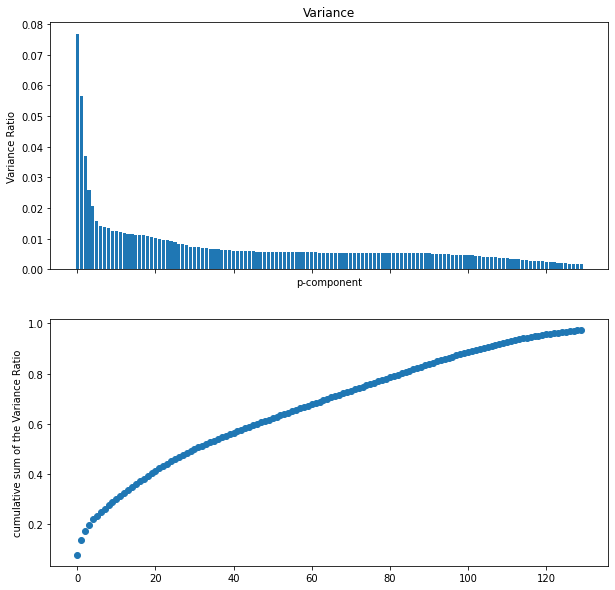

In [53]:
# Investigate the variance accounted for by each principal component.

f,axs = plt.subplots(2, sharex=True,figsize=(10,10))
 
axs[0].set_title('Variance')


axs[0].bar(x=range(component) ,height=varianceRatio)
axs[1].scatter(x=range(component) ,y=pd.Series(varianceRatio.cumsum()))

axs[0].set_ylabel('Variance Ratio')
axs[1].set_ylabel('cumulative sum of the Variance Ratio')
axs[0].set_xlabel('p-component')
plt.show()

In [38]:
# Re-apply PCA to the data while selecting for number of components to retain.
from sklearn.decomposition import PCA
component=130
pca = PCA(n_components=component)

Data_pca=pca.fit_transform(data)
varianceRatio=pca.explained_variance_ratio_ 


### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)


the variance described by the principle compenent reachs 90% 
with almost 130 component 
which means 90% of the data is represented by 130 component 
which make it the optimum value

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

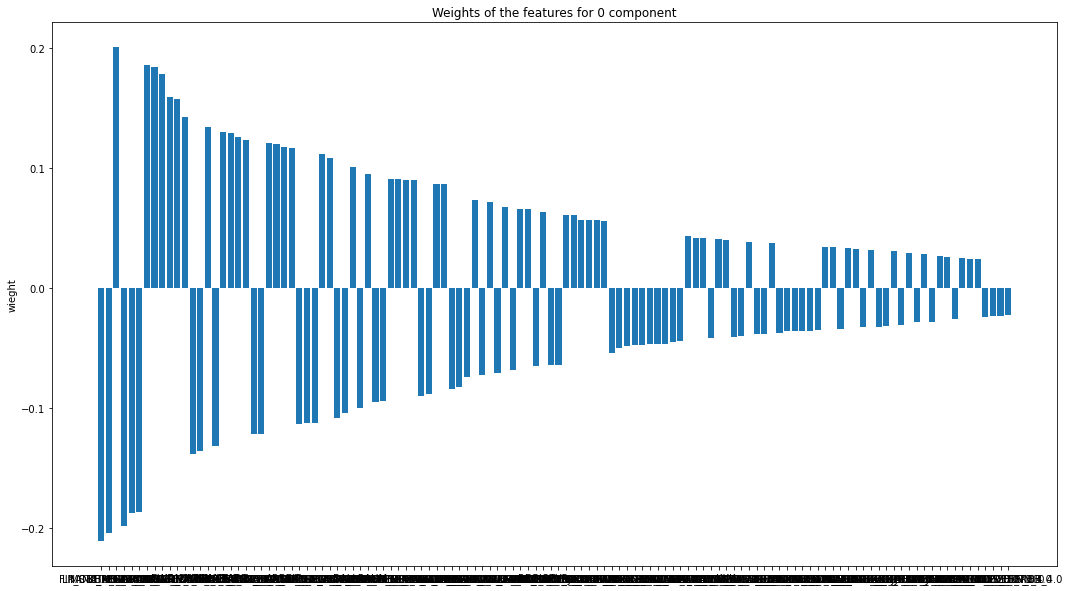

MOBI_REGIO              -0.210659
FINANZ_MINIMALIST       -0.203511
LP_STATUS_GROB_1.0       0.201107
KBA05_ANTG1             -0.197871
KBA05_GBZ               -0.187472
PLZ8_ANTG1              -0.186344
PLZ8_ANTG3               0.185785
HH_EINKOMMEN_SCORE       0.184046
PLZ8_ANTG4               0.178935
ORTSGR_KLS9              0.159325
EWDICHTE                 0.157399
FINANZ_HAUSBAUER         0.142899
PLZ8_GBZ                -0.137776
KONSUMNAEHE             -0.135507
FINANZ_SPARER            0.134426
INNENSTADT              -0.131613
LP_STATUS_FEIN_1.0       0.130385
KBA05_ANTG4              0.129181
PLZ8_ANTG2               0.125905
FINANZTYP_1              0.124027
LP_STATUS_FEIN_10.0     -0.121720
LP_STATUS_GROB_5.0      -0.121720
KBA05_ANTG3              0.121028
LP_STATUS_FEIN_2.0       0.120242
ARBEIT                   0.117653
ANZ_HAUSHALTE_AKTIV      0.116938
LP_STATUS_GROB_4.0      -0.112659
ALTERSKATEGORIE_GROB    -0.111859
LP_STATUS_FEIN_9.0      -0.111823
CAMEO_DEUG_201

In [54]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def Component_Weights(pca,component_number,number_of_features=10,plot=False) :

    i=component_number
    comp_wieghts=pd.DataFrame( pca.components_ , columns=pca.feature_names_in_)

    wieghts=comp_wieghts.iloc[i].sort_values(ascending=False,key=lambda x: abs(x))

    wieghts=wieghts.iloc[:number_of_features]
    if plot :
        plt.rcParams["figure.figsize"] = (18, 10)
        plt.Figure()
        plt.bar(x=wieghts.index ,height=wieghts.values)
        plt.ylabel('wieght')
        plt.title(f'Weights of the features for {i} component')
        plt.show()
    return wieghts

Component_Weights(pca,0,number_of_features=120,plot=True)

In [ ]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

Component_Weights(pca,1,number_of_features=200,plot=True)

In [ ]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

Component_Weights(pca,2,number_of_features=200,plot=False)

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

Overall Interpretation :
- Directionality: Positive and negative weights help to understand how different features  influence the principal components. Features with positive weights move the component in one direction, while features with negative weights move it in the opposite direction.

- Feature Importance: The magnitude of the weights indicates the importance of each feature in the formation of the principal component. Larger magnitudes mean greater influence.
    - for example component number 0 : 
        - MOBI_REGIO              -0.212414
        - LP_STATUS_GROB_1.0       0.203386
        - KBA05_ANTG1             -0.197791
        - FINANZ_MINIMALIST       -0.197778
        - PLZ8_ANTG3               0.191088
        - PLZ8_ANTG1              -0.190011
        - KBA05_GBZ               -0.189756
        - HH_EINKOMMEN_SCORE       0.188676
        - PLZ8_ANTG4               0.184524
        - ORTSGR_KLS9              0.166269
        - EWDICHTE                 0.165372
        - FINANZ_HAUSBAUER         0.156475
        - KONSUMNAEHE             -0.144304
        - PLZ8_GBZ                -0.138068
        - INNENSTADT              -0.136942

which means MOBI_REGIO is the most important feature for PC0 and LP_STATUS_GROB_1.0 is the second most important features and so forth 


- Data Structure: By examining which features have high positive or negative weights across different components, you can infer relationships between features and underlying patterns in the data.

MOBI_REGIO has negative correlation/relation with LP_STATUS_GROB_1.0 however 
MOBI_REGIO has postitive correlation/relation with KBA05_ANTG1

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [ ]:
# Over a number of different cluster counts...
%%script echo skipping
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

K_scores=[]
for k in range(1,25) :
    kmeans = KMeans(n_clusters=k, random_state=42).fit(Data_pca)
    score=kmeans.score(Data_pca) 
    K_scores.append([k,score])


In [ ]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
%%script echo skipping


k=np.array(K_scores)
plt.Figure()
plt.plot(k[:,0],-k[:,1] , 'ro' ,linewidth=10.0)
plt.show()

In [60]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
from sklearn.cluster import KMeans
optimum_number_clusters=15
kmeans = KMeans(n_clusters=optimum_number_clusters, random_state=42).fit(Data_pca)

predictions=kmeans.predict(Data_pca)
generalPopulatio['customerSegemnt']=predictions

import joblib 

joblib.dump(generalPopulatio,'training_data.pickle')
joblib.dump(kmeans,'kmeans.pickle')

['kmeans.pickle']

### Discussion 3.1: Apply Clustering to General Population

the Optimum number of clusters/ segments is 15 clusters 
after the 15 clusters the score which the avg distance between the center of the cluster and the point in the cluster 
is not changing significantly 

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [61]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',sep=';' )
FeatureSummary=pd.read_csv('AZDIAS_Feature_Summary.csv',sep=';' )
 

FeatureSummary.drop( FeatureSummary[FeatureSummary['attribute'] == 'GEBAEUDETYP'].index ,inplace=True )
customers.drop(['GEBAEUDETYP'],axis=1,inplace=True)
 

In [62]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
scalar=joblib.load('scalar.pickle')
cleaned_data,feature_in=clean_data(customers,FeatureSummary,percentage_threshold=30,use_columns=input_features)

cleaned_data=cleaned_data.apply(lambda X : pd.to_numeric(X, errors='coerce').fillna(0).astype(float)) 
cleaned_data.dropna(inplace=True)

scalarFeatures=scalar.feature_names_in_

scaled_data=pd.DataFrame()
scaled_data[scalarFeatures] =scalar.transform( cleaned_data[scalarFeatures] )

transformed_data=pca.transform(scaled_data)
predictions=kmeans.predict(transformed_data)

cleaned_data['customerSegemnt']=predictions

joblib.dump(cleaned_data,'cleaned_data.pickle')


C:\Users\yazan\AppData\Local\Temp\ipykernel_19808\57844654.py:136: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\yazan\AppData\Local\Temp\ipykernel_19808\3100293462.py:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\yazan\AppData\Local\Temp\ipykernel_19808\3100293462.py:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Use

['cleaned_data.pickle']

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
1                   1.0        2.0                1.0            5.0   
2                   3.0        2.0                1.0            4.0   
4                   3.0        1.0                4.0            3.0   
5                   1.0        2.0                3.0            1.0   
6                   2.0        2.0                1.0            5.0   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
1               2.0             5.0                    4.0               5.0   
2               1.0             2.0                    3.0               5.0   
4               4.0             1.0                    3.0               2.0   
5               5.0             2.0                    2.0               5.0   
6               1.0             5.0                    4.0               3.0   

   GREEN_AVANTGARDE  HEALTH_TYP  RETOURTYP_BK_S  SEMIO_SOZ  SEMIO_FAM  \
1               0.0         3.0             1.0        5.0        4.0   
2               1.0         3.0             3.0        4.0        1.0   
4               0.0         3.0             5.0        6.0        4.0   
5               0.0         3.0             3.0        2.0        4.0   
6               0.0         2.0             4.0        2.0        5.0   

   SEMIO_REL  SEMIO_MAT  SEMIO_VERT  SEMIO_LUST  SEMIO_ERL  SEMIO_KULT  \
1        4.0        3.0         1.0         2.0        2.0         3.0   
2        3.0        3.0         4.0         4.0        6.0         3.0   
4        4.0        2.0         7.0         4.0        4.0         6.0   
5        7.0        4.0         2.0         2.0        2.0         5.0   
6        5.0        7.0         2.0         6.0        5.0         5.0   

   SEMIO_RAT  SEMIO_KRIT  SEMIO_DOM  SEMIO_KAEM  SEMIO_PFLICHT  SEMIO_TRADV  \
1        6.0         4.0        7.0         4.0            7.0          6.0   
2        4.0         7.0        7.0         7.0            3.0          3.0   
4        2.0         3.0        2.0         2.0            4.0          2.0   
5        7.0         4.0        4.0         4.0            7.0          6.0   
6        7.0         7.0        4.0         7.0            7.0          7.0   

   SOHO_KZ  VERS_TYP  ANZ_PERSONEN  ANZ_TITEL  HH_EINKOMMEN_SCORE  \
1      1.0       2.0           2.0        0.0                 6.0   
2      0.0       1.0           1.0        0.0                 4.0   
4      0.0       2.0           4.0        0.0                 5.0   
5      0.0       2.0           1.0        0.0                 5.0   
6      0.0       1.0           1.0        0.0                 6.0   

   W_KEIT_KIND_HH  WOHNDAUER_2008  ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  \
1             3.0             9.0                 11.0           0.0   
2             3.0             9.0                 10.0           0.0   
4             2.0             9.0                  3.0           0.0   
5             6.0             9.0                  5.0           0.0   
6             3.0             9.0                  4.0           0.0   

   KONSUMNAEHE  MIN_GEBAEUDEJAHR  OST_WEST_KZ  KBA05_ANTG1  KBA05_ANTG2  \
1          1.0            1992.0          0.0          0.0          0.0   
2          5.0            1992.0          0.0          1.0          3.0   
4          4.0            1992.0          0.0          1.0          4.0   
5          5.0            1992.0          0.0          2.0          2.0   
6          5.0            1992.0          0.0          3.0          2.0   

   KBA05_ANTG3  KBA05_ANTG4  KBA05_GBZ  BALLRAUM  EWDICHTE  INNENSTADT  \
1          0.0          2.0        1.0       6.0       3.0         8.0   
2          1.0          0.0        3.0       2.0       4.0         4.0   
4          1.0          0.0        3.0       2.0       5.0         1.0   
5          0.0          0.0        4.0       6.0       2.0         7.0   
6          0.0          0.0        3.0       6.0       4.0   

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
0                   4.0        1.0                5.0            1.0   
2                   4.0        2.0                5.0            1.0   
4                   3.0        1.0                3.0            1.0   
5                   3.0        1.0                5.0            1.0   
6                   4.0        1.0                5.0            1.0   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
0               5.0             1.0                    2.0               2.0   
2               5.0             1.0                    4.0               4.0   
4               4.0             4.0                    5.0               2.0   
5               5.0             1.0                    2.0               3.0   
6               5.0             1.0                    1.0               2.0   

   GREEN_AVANTGARDE  HEALTH_TYP  RETOURTYP_BK_S  SEMIO_SOZ  SEMIO_FAM  \
0               1.0         1.0             5.0        6.0        5.0   
2               1.0         2.0             5.0        2.0        2.0   
4               0.0         3.0             5.0        4.0        5.0   
5               1.0         3.0             3.0        6.0        4.0   
6               1.0         2.0             5.0        4.0        2.0   

   SEMIO_REL  SEMIO_MAT  SEMIO_VERT  SEMIO_LUST  SEMIO_ERL  SEMIO_KULT  \
0        2.0        6.0         6.0         7.0        3.0         4.0   
2        1.0        3.0         3.0         7.0        7.0         1.0   
4        4.0        6.0         5.0         6.0        4.0         5.0   
5        4.0        1.0         7.0         6.0        4.0         6.0   
6        5.0        1.0         6.0         5.0        3.0         4.0   

   SEMIO_RAT  SEMIO_KRIT  SEMIO_DOM  SEMIO_KAEM  SEMIO_PFLICHT  SEMIO_TRADV  \
0        1.0         3.0        1.0         1.0            2.0          1.0   
2        2.0         7.0        5.0         6.0            4.0          1.0   
4        5.0         3.0        5.0         2.0            5.0          4.0   
5        2.0         5.0        5.0         3.0            3.0          4.0   
6        3.0         3.0        1.0         2.0            2.0          4.0   

   SOHO_KZ  VERS_TYP  ANZ_PERSONEN  ANZ_TITEL  HH_EINKOMMEN_SCORE  \
0      0.0       1.0           2.0        0.0                 1.0   
2      0.0       2.0           1.0        0.0                 1.0   
4      0.0       2.0           4.0        0.0                 6.0   
5      0.0       2.0           2.0        0.0                 1.0   
6      0.0       1.0           2.0        0.0                 2.0   

   W_KEIT_KIND_HH  WOHNDAUER_2008  ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  \
0             6.0             9.0                  1.0           0.0   
2             6.0             9.0                  1.0           0.0   
4             2.0             9.0                  7.0           0.0   
5             6.0             9.0                  1.0           0.0   
6             6.0             9.0                  1.0           0.0   

   KONSUMNAEHE  MIN_GEBAEUDEJAHR  OST_WEST_KZ  KBA05_ANTG1  KBA05_ANTG2  \
0          5.0            1992.0          0.0          2.0          2.0   
2          1.0            1992.0          0.0          2.0          2.0   
4          1.0            1992.0          0.0          0.0          3.0   
5          2.0            1992.0          0.0          2.0          2.0   
6          4.0            1992.0          0.0          4.0          1.0   

   KBA05_ANTG3  KBA05_ANTG4  KBA05_GBZ  BALLRAUM  EWDICHTE  INNENSTADT  \
0          0.0          0.0        4.0       3.0       2.0         4.0   
2          0.0          0.0        3.0       7.0       4.0         1.0   
4          2.0          0.0        3.0       3.0       4.0         4.0   
5          1.0          0.0        3.0       7.0       5.0         8.0   
6          0.0          0.0        4.0       6.0       2.0   

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

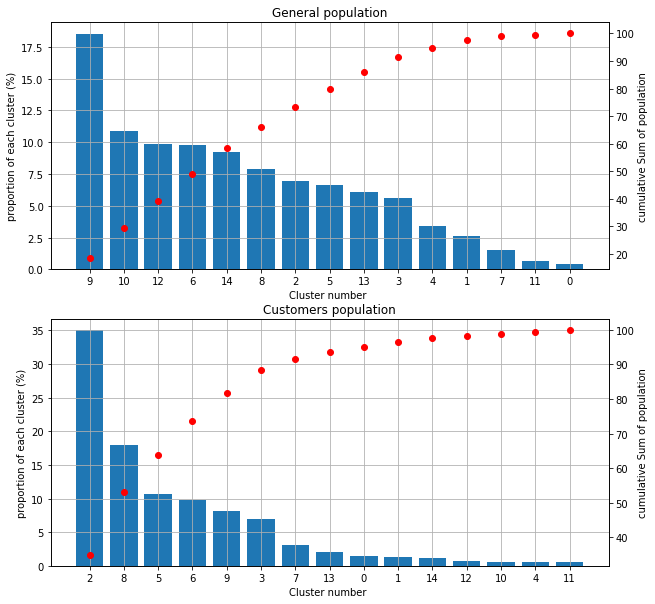

In [79]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

display(generalPopulatio.head())
display(cleaned_data.head())
display(generalPopulatio.columns==cleaned_data.columns)
 

training_dataProp=generalPopulatio['customerSegemnt'].value_counts()/len(data)*100 
customer_dataProp= cleaned_data['customerSegemnt'].value_counts()/len(cleaned_data)*100


f, axs = plt.subplots(2,figsize=(10,10))

ax2 = axs[0].twinx()
axs[0].bar(x=training_dataProp.index  , height=training_dataProp.values )
ax2.scatter(x=training_dataProp.index  , y=np.cumsum(training_dataProp.values), c='r',label='cumulative Sum of population' )

ax3 = axs[1].twinx()
axs[1].bar(x=customer_dataProp.index  , height=customer_dataProp.values )
ax3.scatter(x=customer_dataProp.index  , y=np.cumsum(customer_dataProp.values ), c='r' ,label='cumulative Sum of population')

axs[0].set_title('General population')
axs[1].set_title('Customers population')
for ax in axs : 
    ax.set_xticks(range(optimum_number_clusters))
    ax.set_xlabel('Cluster number ')
    ax.set_ylabel('proportion of each cluster (%)')
    ax.grid()
 

ax2.set_ylabel('cumulative Sum of population')
ax3.set_ylabel('cumulative Sum of population')
plt.show()


nearly 90% of the customers belongs to only 6 clusters out of 15 

the customers mainly belongs to clusters 2,8,5,6,9,3

less than 10% of the customer belongs to clusters 7,13,0,1,14,12,10,4,11

PCA helped to show the features which has the largest variance in the data 
which means trying to map the clusters to the top important features will 
help to give these clusters a labels , and to understand by of the features 

We can map the predicted clusters to the cleaned data set before the standard scaling 
which helps looking on the raw data , this happens by adding a column to the cleaned 
data frame with the predictions  just as following :

cleaned_data['customerSegemnt']=predictions

this instead  of using '.inverse_transorm' for  'PCA' and 'StandardScalar'

I will use plotly to visulize 3d graphs showing the top 4 most important feature 
for principle component 0 from the PCA analysis for all the clsuters 
three features will be on x,y,z axis , and the fourth feature will the size of the marker 



In [24]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?



generalPopulatio=joblib.load('training_data.pickle')
cleaned_data=joblib.load('cleaned_data.pickle')

generalPopulatio['customerSegemnt']=generalPopulatio['customerSegemnt'].astype(str  )
cleaned_data['customerSegemnt']=cleaned_data['customerSegemnt'].astype(str  )


#largets_cluster=customer_dataProp.nlargest(4).index

#generation	movement_Avantgarde	movement_Mainstream	nation_E	nation_EW	nation_W	tens	ones

X_feature_name='MOBI_REGIO'
Y_feature_name='KBA05_GBZ'
Z_feature_name='LP_STATUS_GROB_1.0'
fourth_feature_name='PLZ8_ANTG3'
 
fig = px.scatter_3d(cleaned_data,
                     x=X_feature_name, y=Y_feature_name, z=Z_feature_name,
                     color="customerSegemnt",#marginal_x="histogram", marginal_y="histogram",
                     symbol="customerSegemnt",
                     size=fourth_feature_name )
fig.show()


#fig = px.scatter_3d(generalPopulatio,
#                    x=X_feature_name, y=Y_feature_name, z=Z_feature_name,
#                     color="customerSegemnt",#marginal_x="histogram", marginal_y="histogram",
#                     symbol="customerSegemnt",
#                     size=fourth_feature_name )
#fig.show()

'''
top feature from PCA-PC0
MOBI_REGIO              -0.210659
FINANZ_MINIMALIST       -0.203511
LP_STATUS_GROB_1.0       0.201107
KBA05_ANTG1             -0.197871
KBA05_GBZ               -0.187472
PLZ8_ANTG1              -0.186344
PLZ8_ANTG3               0.185785
HH_EINKOMMEN_SCORE       0.184046
PLZ8_ANTG4               0.178935
ORTSGR_KLS9              0.159325
EWDICHTE                 0.157399
FINANZ_HAUSBAUER         0.142899
PLZ8_GBZ                -0.137776
KONSUMNAEHE             -0.135507
FINANZ_SPARER            0.134426'''



'\ntop feature from PCA-PC0\nMOBI_REGIO              -0.210659\nFINANZ_MINIMALIST       -0.203511\nLP_STATUS_GROB_1.0       0.201107\nKBA05_ANTG1             -0.197871\nKBA05_GBZ               -0.187472\nPLZ8_ANTG1              -0.186344\nPLZ8_ANTG3               0.185785\nHH_EINKOMMEN_SCORE       0.184046\nPLZ8_ANTG4               0.178935\nORTSGR_KLS9              0.159325\nEWDICHTE                 0.157399\nFINANZ_HAUSBAUER         0.142899\nPLZ8_GBZ                -0.137776\nKONSUMNAEHE             -0.135507\nFINANZ_SPARER            0.134426'

### Discussion 3.3: Compare Customer Data to Demographics Data

Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?

Yes , obvusley can map the features shown in the graph to it is actual meaning 

the top four feature for principle component PC0 are :

    - MOBI_REGIO :Movement patterns
        -  1: very high movement
        -  2: high movement
        -  3: middle movement
        -  4: low movement
        -  5: very low movement
        -  6: none           

    - PLZ8_ANTG3 : Number of 6-10 family houses in the PLZ8 region:
        -  1: lower share of 6-10 family homes
        -  2: average share of 6-10 family homes
        -  3: high share of 6-10 family homes

    - LP_STATUS_GROB_1.0  :
        -  0: not low-income earners
        -  1: low-income earners

    - KBA05_GBZ: Number of buildings in the microcell
        -  1: 1-2 buildings
        -  2: 3-4 buildings
        -  3: 5-16 buildings
        -  4: 17-22 buildings
        -  5: >=23 buildings

###Cluster 2 which has the majority of the customers in the mail list are :

    - does not include customers with  'very low movement' which has Number of buildings in the microcell<4
    - includes low-income earners and not low-income earners   
    - have average to high share of family homes



cluster 11 which has a small percentage of the customers 

    - have  'Middle','Low','very low' movment pattern and 
    - average' family houses in the PLZ8 region
    - not low-income earners   
    - Number of buildings in the microcell >5  




> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.

In [22]:
vlcouns=cleaned_data[['nation_EW',	'nation_W',	'nation_E'	,'tens'	,'ones','customerSegemnt']].value_counts()/len(cleaned_data)*100

display( vlcouns  ) 

nation_EW  nation_W  nation_E  tens  ones  customerSegemnt
0.0        0.0       0.0       0.0   0.0   8                  7.141219
                                           5                  4.262415
                                           6                  3.925811
1.0        0.0       0.0       1.0   4.0   2                  3.413155
                               2.0   4.0   2                  3.287316
0.0        0.0       0.0       0.0   0.0   9                  3.189992
                                           3                  2.619687
                                           2                  2.591171
1.0        0.0       0.0       4.0   1.0   2                  2.164682
                                     3.0   2                  1.855353
                               2.0   5.0   2                  1.739432
                               1.0   5.0   2                  1.663185
                               5.0   1.0   2                  1.611733
                  